In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import scipy.ndimage as ndimage
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric as pyg
import torch_geometric.loader as pyg_loader
import pytorch_lightning as pl
from torch.utils.data import Dataset
from shutil import copyfile
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from flygym.vision import Retina
from vision_model import VisualFeaturePreprocessor

In [3]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Arial"

In [4]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

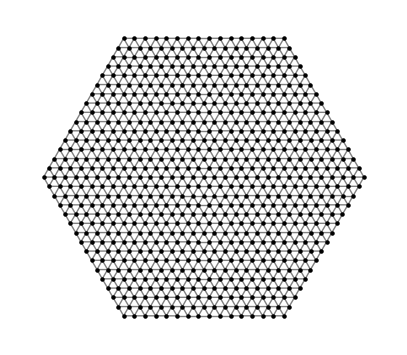

In [5]:
retina = Retina()
ommatidia_id_map = retina.ommatidia_id_map
dilation_kernel = np.ones((5, 5), dtype=bool)
edges = set()
node_pos = dict()
for ommatidium_id in range(1, ommatidia_id_map.max() + 1):
    mask_pred = ommatidia_id_map == ommatidium_id
    node_pos[ommatidium_id] = np.mean(np.argwhere(mask_pred), axis=0)
    dilated_mask = ndimage.binary_dilation(mask_pred, dilation_kernel)
    neighbor_ids = np.unique(ommatidia_id_map[dilated_mask])
    for neighbor_id in neighbor_ids:
        if neighbor_id not in [0, ommatidium_id]:
            pair = sorted([ommatidium_id, neighbor_id])
            edges.add(tuple(pair))
graph = nx.from_edgelist(edges)
with open("data/vision/ommatidia_graph.pkl", "wb") as f:
    pickle.dump(graph, f)
pg_graph = pyg.utils.from_networkx(graph)
fig, ax = plt.subplots(figsize=(5, 5))
nx.draw(
    graph,
    pos=node_pos,
    node_size=5,
    width=1,
    node_color="black",
    edge_color="gray",
    ax=ax,
)
ax.set_aspect("equal")
fig.savefig("outputs/ommatidia_graph.pdf", transparent=True)

In [6]:
with open("data/vision/visual_training_data.pkl", "rb") as f:
    visual_training_data_all = pickle.load(f)

[3.00971441 1.9819244 ]


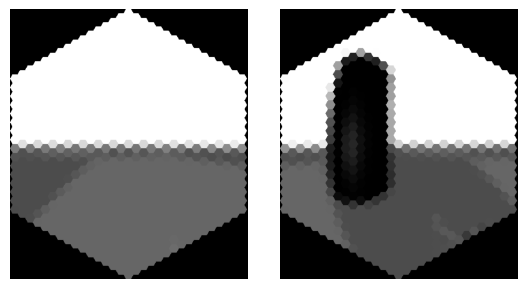

In [7]:
sample_idx = 16
sample = visual_training_data_all[sample_idx]
img_human_l = retina.hex_pxls_to_human_readable(sample["visual_input"][0].max(-1))
img_human_r = retina.hex_pxls_to_human_readable(sample["visual_input"][1].max(-1))
fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)
axs[0].imshow(img_human_l, cmap="gray", vmin=0, vmax=1)
axs[0].axis("off")
axs[1].imshow(img_human_r, cmap="gray", vmin=0, vmax=1)
axs[1].axis("off")
print(sample["obstacle_position_rel"])

In [8]:
class VisualInputSampleDataset(Dataset):
    fov_lim = np.deg2rad(270 / 2)

    def __init__(
        self, dataset_path, noise_std=0.05, max_dist=10, obj_threshold=50 / 255
    ):
        super().__init__()
        with open(dataset_path, "rb") as f:
            self.dataset = pickle.load(f)
        self.noise_std = noise_std
        self.max_dist = max_dist
        self.obj_threshold = obj_threshold

        # Calculate x-y positions of each ommatidium
        self.coms = np.empty((retina.num_ommatidia_per_eye, 2))
        for i in range(retina.num_ommatidia_per_eye):
            mask = retina.ommatidia_id_map == i + 1
            self.coms[i, :] = np.argwhere(mask).mean(axis=0)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        etr = self.dataset[index]
        intensities = etr["visual_input"].astype(np.float32)

        # Centroid y position and relative size
        y_pos_li = []
        size_li = []
        for i in range(2):
            obj_mask = intensities[i].max(axis=1) < self.obj_threshold
            obj_mask[~retina.pale_type_mask] = False
            obj_ommatidia_coords = self.coms[obj_mask]
            obj_size = obj_ommatidia_coords.shape[0]
            if obj_size > 0:
                _, mean_y = obj_ommatidia_coords.mean(axis=0)
                mean_y /= retina.ncols
                rel_size = obj_size / retina.num_ommatidia_per_eye
                rel_size /= retina.pale_type_mask.sum() / retina.pale_type_mask.size
                if i == 0:
                    mean_y = 1 - mean_y
            else:
                mean_y = 0
                rel_size = 0
            y_pos_li.append(mean_y)
            size_li.append(rel_size)
        azimuth_pos_tensor = torch.tensor(y_pos_li).float()
        rel_size_tensor = torch.tensor(size_li).float()

        # Process visual input
        mask = intensities > 0
        intensities_masked = intensities[mask]
        intensities_masked += np.random.normal(
            scale=self.noise_std, size=intensities_masked.shape
        )
        intensities[mask] = intensities_masked
        intensities = np.clip(intensities, 0, 1)
        intensities = torch.tensor(intensities).float()
        graph_left = pg_graph.clone()
        graph_left.x = intensities[0, :]
        graph_right = pg_graph.clone()
        graph_right.x = intensities[1, :]

        # Get target output
        obstacle_position_rel = etr["obstacle_position_rel"]
        direction = np.arctan2(obstacle_position_rel[1], obstacle_position_rel[0])
        distance = np.linalg.norm(obstacle_position_rel)
        angular_pos = torch.tensor([direction, distance / self.max_dist]).float()

        # Is object found?
        mask = np.array([-self.fov_lim < direction < self.fov_lim])
        mask = torch.tensor(mask).int()[0]

        return {
            "intensity": intensities.float(),
            "graph_left": graph_left,
            "graph_right": graph_right,
            "angular_pos": angular_pos,
            "object_found": mask,
            "azimuth": azimuth_pos_tensor,
            "rel_size": rel_size_tensor,
        }

In [9]:
ds = VisualInputSampleDataset("data/vision/visual_training_data.pkl")

In [10]:
def visualize(etr):
    intensities = etr["intensity"].detach().cpu().numpy()
    img_human_l = retina.hex_pxls_to_human_readable(intensities[0].max(-1))
    img_human_r = retina.hex_pxls_to_human_readable(intensities[1].max(-1))
    fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)
    axs[0].imshow(img_human_l, cmap="gray", vmin=0, vmax=1)
    axs[0].axis("off")
    axs[1].imshow(img_human_r, cmap="gray", vmin=0, vmax=1)
    axs[1].axis("off")
    print(etr["angular_pos"], etr["object_found"])
    print(etr["azimuth"], etr["rel_size"])

tensor([1.9711, 0.6527]) tensor(1, dtype=torch.int32)
tensor([0.5222, 0.8624]) tensor([0.0231, 0.1389])


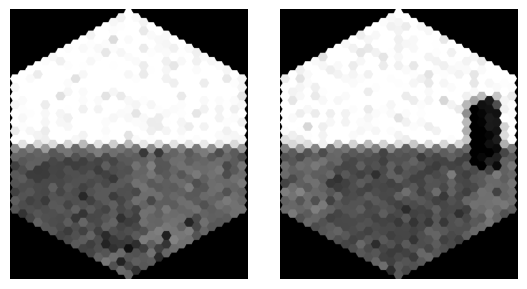

In [11]:
visualize(ds[22])

In [12]:
ds[22]

{'intensity': tensor([[[1.0000, 0.0000],
          [1.0000, 0.0000],
          [0.9815, 0.0000],
          ...,
          [0.4022, 0.0000],
          [0.3636, 0.0000],
          [0.5031, 0.0000]],
 
         [[0.9760, 0.0000],
          [1.0000, 0.0000],
          [1.0000, 0.0000],
          ...,
          [0.4208, 0.0000],
          [0.3444, 0.0000],
          [0.4731, 0.0000]]]),
 'graph_left': Data(edge_index=[2, 4140], num_nodes=721, x=[721, 2]),
 'graph_right': Data(edge_index=[2, 4140], num_nodes=721, x=[721, 2]),
 'angular_pos': tensor([1.9711, 0.6527]),
 'object_found': tensor(1, dtype=torch.int32),
 'azimuth': tensor([0.5222, 0.8624]),
 'rel_size': tensor([0.0231, 0.1389])}

In [13]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

train_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [0.8, 0.1, 0.1])
train_loader = pyg_loader.DataLoader(
    train_ds, batch_size=32, shuffle=True, num_workers=8
)
val_loader = pyg_loader.DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=8)
test_loader = pyg_loader.DataLoader(
    test_ds, batch_size=32, shuffle=False, num_workers=8
)

In [14]:
model_path = "data/vision/visual_preprocessor.pt"
retrain = True

if retrain:
    model = VisualFeaturePreprocessor()
    logger = pl.loggers.TensorBoardLogger("logs/vision", name="visual_preprocessor")
    checkpoint = pl.callbacks.ModelCheckpoint(save_top_k=5, monitor="val_total_loss")
    trainer = pl.Trainer(
        max_epochs=150,
        deterministic=True,
        logger=logger,
        log_every_n_steps=15,
        enable_progress_bar=True,
    )
    trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    best_model_path = trainer.checkpoint_callback.best_model_path
    print("Best model:", best_model_path)
    copyfile(best_model_path, model_path)

model = VisualFeaturePreprocessor.load_from_checkpoint(model_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params
------------------------------------------
0 | conv1   | GCNConv       | 12    
1 | conv2   | GCNConv       | 10    
2 | linear1 | Linear        | 46.2 K
3 | linear2 | Linear        | 272   
4 | linear3 | Linear        | 119   
5 | _f1     | BinaryF1Score | 0     
6 | _r2     | R2Score       | 0     
------------------------------------------
46.6 K    Trainable params
0         Non-trainable params
4

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


Best model: logs/vision/visual_preprocessor/version_1/checkpoints/epoch=149-step=75000.ckpt


In [15]:
model_cpu = model.to("cpu")
angle_pred_all = np.zeros((len(test_ds)))
dist_pred_all = np.zeros((len(test_ds)))
mask_pred_all = np.zeros((len(test_ds)))
azimuth_pred_all = np.zeros((len(test_ds), 2))
rel_size_pred_all = np.zeros((len(test_ds), 2))
angle_label_all = np.zeros((len(test_ds)))
dist_label_all = np.zeros((len(test_ds)))
mask_label_all = np.zeros((len(test_ds)))
azimuth_label_all = np.zeros((len(test_ds), 2))
rel_size_label_all = np.zeros((len(test_ds), 2))


for i, sample in tqdm(enumerate(test_ds), total=len(test_ds)):
    pred = model_cpu(sample["graph_left"], sample["graph_right"])
    angle_pred_all[i] = pred["angle"].detach().cpu().numpy()
    dist_pred_all[i] = pred["dist"].detach().cpu().numpy()
    mask_pred_all[i] = pred["mask"].detach().cpu().numpy()
    azimuth_pred_all[i, :] = pred["azimuth"].detach().cpu().numpy()
    rel_size_pred_all[i, :] = pred["rel_size"].detach().cpu().numpy()
    angle_label_all[i] = sample["angular_pos"][0].detach().cpu().numpy()
    dist_label_all[i] = sample["angular_pos"][1].detach().cpu().numpy()
    mask_label_all[i] = sample["object_found"].detach().cpu().numpy()
    azimuth_label_all[i, :] = sample["azimuth"].detach().cpu().numpy()
    rel_size_label_all[i, :] = sample["rel_size"].detach().cpu().numpy()

  0%|          | 0/2000 [00:00<?, ?it/s]

/tmp/ipykernel_108321/3667060022.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  angle_pred_all[i] = pred["angle"].detach().cpu().numpy()
/tmp/ipykernel_108321/3667060022.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dist_pred_all[i] = pred["dist"].detach().cpu().numpy()
/tmp/ipykernel_108321/3667060022.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mask_pred_all[i] = pred["mask"].detach().cpu().numpy()
100%|██████████| 2000/2000 [00:02<00:00, 819

In [16]:
angle_label_all

array([-2.31375456, -1.30413115,  2.39320946, ..., -1.65553689,
        1.41733217,  3.1300261 ])

In [17]:
metrics = model.get_metrics(
    angle_pred=torch.tensor(angle_pred_all),
    dist_pred=torch.tensor(dist_pred_all),
    mask_pred=torch.tensor(mask_pred_all),
    azimuth_pred=torch.tensor(azimuth_pred_all),
    rel_size_pred=torch.tensor(rel_size_pred_all),
    angle_label=torch.tensor(angle_label_all),
    dist_label=torch.tensor(dist_label_all),
    mask_label=torch.tensor(mask_label_all),
    azimuth_label=torch.tensor(azimuth_label_all),
    rel_size_label=torch.tensor(rel_size_label_all),
)
metrics

{'angle_r2': 0.9865737588216456,
 'dist_r2': tensor(0.9588),
 'detection_f1': tensor(0.9324),
 'azimuth_r2': tensor(0.7450),
 'size_r2': tensor(0.8407)}

/tmp/ipykernel_108321/2990143430.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig("outputs/vision_model_stats.pdf", transparent=True)
/home/tlam/miniconda3/envs/flygym/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/tlam/miniconda3/envs/flygym/lib/python3.11/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


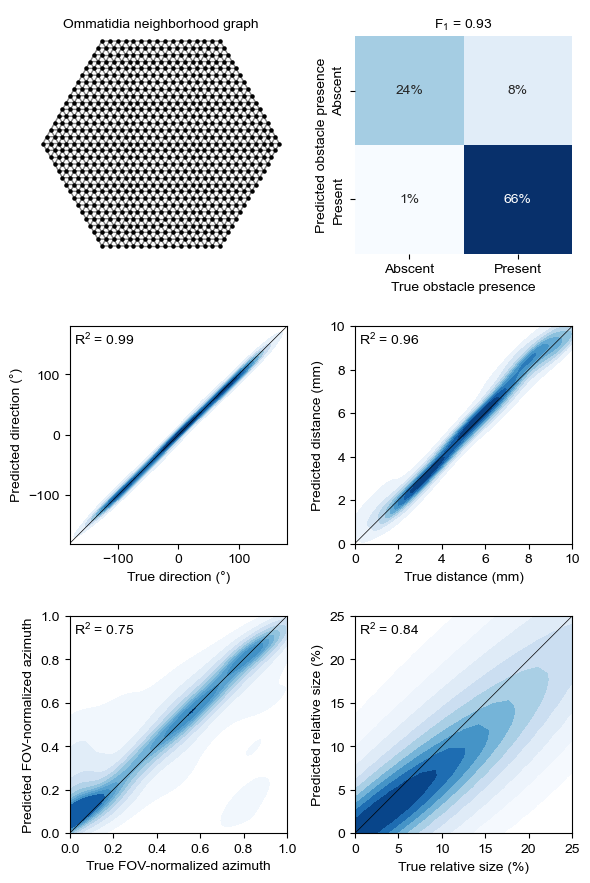

In [18]:
mask = mask_pred_all > 0.5

pad = 0.02

fig, axs = plt.subplots(3, 2, figsize=(6, 9), tight_layout=True)

ax = axs[1, 0]
sns.kdeplot(
    x=np.rad2deg(angle_label_all[mask]),
    y=np.rad2deg(angle_pred_all[mask]),
    fill=True,
    cmap="Blues",
    ax=ax,
)
ax.plot([-180, 180], [-180, 180], color="black", linewidth=0.5)
ax.set_aspect("equal")
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)
ax.set_xlabel(r"True direction (°)")
ax.set_ylabel(r"Predicted direction (°)")
# ax.set_title(f"R$^2$ = {np.round(metrics['angle_r2'], 2):.2f}", fontsize=10)
ax.text(
    0 + pad,
    1 - pad,
    f"R$^2$ = {np.round(metrics['angle_r2'], 2):.2f}",
    fontsize=10,
    va="top",
    transform=ax.transAxes,
)

ax = axs[1, 1]
sns.kdeplot(
    x=dist_label_all[mask] * ds.max_dist,
    y=dist_pred_all[mask] * ds.max_dist,
    fill=True,
    cmap="Blues",
    ax=ax,
)
ax.plot([0, 10], [0, 10], color="black", linewidth=0.5)
ax.set_aspect("equal")
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_xlabel(r"True distance (mm)")
ax.set_ylabel(r"Predicted distance (mm)")
ax.text(
    0 + pad,
    1 - pad,
    f"R$^2$ = {np.round(metrics['dist_r2'], 2):.2f}",
    fontsize=10,
    va="top",
    transform=ax.transAxes,
)

ax = axs[0, 1]
conf_mat = confusion_matrix(mask_pred_all > 0.5, mask_label_all > 0.5)
sns.heatmap(
    conf_mat / conf_mat.sum(), annot=True, fmt=".0%", cmap="Blues", cbar=False, ax=ax
)
ax.set_aspect("equal")
ax.set_xticklabels(["Abscent", "Present"])
ax.set_yticklabels(["Abscent", "Present"])
ax.set_xlabel("True obstacle presence")
ax.set_ylabel("Predicted obstacle presence")
f1 = ax.set_title(f"F$_1$ = {np.round(metrics['detection_f1'], 2):.2f}", fontsize=10)

ax = axs[2, 0]
sns.kdeplot(
    x=azimuth_label_all[mask].flatten(),
    y=azimuth_pred_all[mask].flatten(),
    fill=True,
    cmap="Blues",
    ax=ax,
)
ax.plot([-180, 180], [-180, 180], color="black", linewidth=0.5)
ax.set_aspect("equal")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel(r"True FOV-normalized azimuth")
ax.set_ylabel(r"Predicted FOV-normalized azimuth")
# ax.set_title(f"R$^2$ = {np.round(metrics['azimuth_r2'], 2):.2f}", fontsize=10)
ax.text(
    0 + pad,
    1 - pad,
    f"R$^2$ = {np.round(metrics['azimuth_r2'], 2):.2f}",
    fontsize=10,
    va="top",
    transform=ax.transAxes,
)

ax = axs[2, 1]
sns.kdeplot(
    x=rel_size_label_all[mask].flatten() * 100,
    y=rel_size_pred_all[mask].flatten() * 100,
    fill=True,
    cmap="Blues",
    ax=ax,
)
ax.plot([0, 100], [0, 100], color="black", linewidth=0.5)
ax.set_aspect("equal")
ax.set_xlim(0, 25)
ax.set_ylim(0, 25)
ax.set_xlabel(r"True relative size (%)")
ax.set_ylabel(r"Predicted relative size (%)")
# ax.set_title(f"R$^2$ = {np.round(metrics['size_r2'], 2):.2f}", fontsize=10)
ax.text(
    0 + pad,
    1 - pad,
    f"R$^2$ = {np.round(metrics['size_r2'], 2):.2f}",
    fontsize=10,
    va="top",
    transform=ax.transAxes,
)

axs[0, 0].axis("off")

bbox_r = axs[0, 1].get_window_extent().transformed(fig.transFigure.inverted())
bbox_b = axs[1, 0].get_window_extent().transformed(fig.transFigure.inverted())

x0 = 0.06
ax = fig.add_axes([x0, bbox_r.y0 - 0.01, bbox_b.x1 - x0, bbox_r.height])

nx.draw(
    graph,
    pos=node_pos,
    node_size=5,
    width=1,
    node_color="black",
    edge_color="gray",
    ax=ax,
)
ax.set_xmargin(0)
ax.set_ymargin(0)
ax.set_aspect("equal")

title = ax.set_title("Ommatidia neighborhood graph", fontsize=10, pad=0)

fig.savefig("outputs/vision_model_stats.pdf", transparent=True)